In [49]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


torch.Size([1, 28, 28])
torch.Size([3, 32, 122])


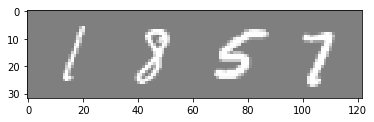

    1     8     5     7


In [33]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Make model
Define CNN 

In [85]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.fc1 = nn.Linear(20 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)

    def forward(self, x):
        # start 1 x 28 x 28
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x, pool_indices_1 = self.pool(x)
        # now 10 x 14 x 14
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x, pool_indices_2 = self.pool(x)
        # now 20 x 7 x 7)
        
        x = x.view(-1, 20 * 7 * 7)
        x = F.relu(self.fc1(x))
        # now 1 x 500
        
        x = F.relu(self.fc2(x))
        # now 1 x 250 
        
        x = self.fc3(x)
        # now 1 x 100
        
        return x, pool_indices_1, pool_indices_2

class Decoder(nn.Module): 
    def __init__(self): 
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(100, 250)
        self.fc2 = nn.Linear(250, 500)
        self.fc3 = nn.Linear(500, 20 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.ConvTranspose2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.ConvTranspose2d(10, 1, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxUnpool2d(2, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, pool_indices_1, pool_indices_2): 
        # start 1 x 100
        
        x = self.fc1(x)
        # now 1 x 250
        
        x = F.relu(self.fc2(x))
        # now 1 x 500
        
        x = F.relu(self.fc3(x))
        # now 1 x 20 * 7 * 7
        
        x = x.view(-1, 20, 7, 7)
        # now 20  x 7 x 7
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x, pool_indices_1)
        # now 10 x 14 x 14
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x, pool_indices_2)
        # now 1 x 28 x 28
        
        x = self.sigmoid(x)
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x, pool_1, pool_2 = self.encoder(x)
        x = self.decoder(x, pool_1, pool_2)
        return x
    
net = Net().to(device)

loss function


In [83]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,
                             weight_decay=1e-5)

training procedure

In [84]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            break

print('Finished Training')

AttributeError: 'Decoder' object has no attribute 'pool'

In [56]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = net(images.to(device))

one = outputs[0]
one

tensor([ 0.0425, -0.0147, -0.0480, -0.0314,  0.0864,  0.0016,  0.0274, -0.0466,
         0.0307,  0.0463, -0.0471,  0.0181,  0.0538,  0.0645,  0.0290, -0.0405,
         0.0024,  0.0438, -0.0144, -0.0551,  0.0370,  0.0375, -0.0034,  0.0033,
        -0.0342, -0.0643,  0.0489, -0.0149,  0.0512, -0.0461,  0.0136,  0.0017,
        -0.0123,  0.0522, -0.0142,  0.0072, -0.0829, -0.0266,  0.0181,  0.0314,
        -0.0508, -0.0258,  0.0481, -0.0081, -0.0239, -0.0172,  0.0513,  0.0513,
        -0.0486, -0.0687, -0.0024, -0.0054, -0.0346, -0.0123,  0.0530, -0.0637,
         0.0043, -0.0434,  0.0549,  0.0221, -0.0276,  0.0476, -0.0231,  0.0003,
         0.0193, -0.0533,  0.0011, -0.0490,  0.0348,  0.0149,  0.0403,  0.0313,
        -0.0135,  0.0235, -0.0117,  0.0607,  0.0027, -0.0274, -0.0198,  0.0144,
         0.0246, -0.0585, -0.0624, -0.0505, -0.0165, -0.0005, -0.0533,  0.0196,
        -0.0531, -0.0467, -0.0193, -0.0351,  0.0184, -0.0539,  0.0361, -0.0140,
        -0.0580,  0.0237, -0.0198,  0.03